# Detecting GAN-generated Facial Deepfakes

### Mattis Haumann (176656), Sven Robert Kurth (175866), Sebastian Uedingslohmann (175867)

GAN-generated facial images are getting more realistic and harder to detect. This can be dangerous, because people can use them for identity fraud or to create fake profiles on social media. Because of that, we need models that can reliably detect these fake images. In this project, we build such models and see how well they can tell real and fake faces apart. We also want to find out if the models can detect fake images from a GAN they have never seen before.

# Install and Load Packages

In [1]:
# Download and install required packages
!pip install seaborn
!pip install kagglehub
!pip install tensorflow
!pip install scikit-learn
!pip install imagehash
!pip install psutil

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 922.4 kB/s eta 0:00:000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 34.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 40.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 5.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 33.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 28

In [2]:
import os
import gc
import time
import random
import tarfile
import hashlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import imagehash
import matplotlib.image as mpimg
import psutil

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, models
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

import kagglehub


2025-05-15 20:04:17.693135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:04:17.698103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-15 20:04:17.710640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747332257.730838    2004 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747332257.736956    2004 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747332257.753952    2004 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

We set a random seed for the Python environment, NumPy, and TensorFlow so that we can reproduce our results. This is essential when working collaboratively and ensured that we are always aligned.

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Load Data

## Download from Kaggle API

In this section, we import the data to Python. We make use of the Kaggle API and only use datasets which were published or updated no longer than one and a half years ago. We use of a combination of real and GAN-generated facial images stemming from the popular FFHQ and CelebA datasets. We decide to use them since they contain diverse images with different ethnicity, poses, and age. The GAN-generated images are generated by four different GANs, including StarGAN, StyleGAN2, StyleGAN3, and ProGAN. Since all of these have different attributes, we want to combine them to create a very diverse dataframe and allow the model to generalize. The image categories contained in the datasets are organized into folders which have to be accessed using the os library.

In [4]:
# Download ArtiFace dataset
artiface = kagglehub.dataset_download("shafiqulalamkhan/artiface")

# Define the path to the dataset
compressed_file = os.path.join(artiface, 'ArtiFace.tar.xz')

# Extract if archive exists
if os.path.exists(compressed_file):
    with tarfile.open(compressed_file, mode='r:xz') as archive:
        archive.extractall(artiface)

100%|██████████| 1.10G/1.10G [00:29<00:00, 40.0MB/s]

Extracting files...


In [5]:
# Define paths to the datasets
path_star_gan       = os.path.join(artiface, 'ArtiFace', 'Fake', 'StarGAN')
path_style_gan_2    = os.path.join(kagglehub.dataset_download("mayankjha146025/fake-face-images-generated-from-different-gans"), 'GAN_Generated_Fake_Images', 'StyleGAN2_256x256')
path_style_gan_3    = os.path.join(kagglehub.dataset_download("mayankjha146025/fake-face-images-generated-from-different-gans"), 'GAN_Generated_Fake_Images', 'StyleGAN3_256x256')
path_pro_gan        = os.path.join(kagglehub.dataset_download("mayankjha146025/fake-face-images-generated-from-different-gans"), 'GAN_Generated_Fake_Images', 'ProGAN_128x128')
path_projected_gan  = os.path.join(artiface, 'ArtiFace', 'Fake', 'ProjectedGAN')
path_real_celeb     = os.path.join(kagglehub.dataset_download("jessicali9530/celeba-dataset"), 'img_align_celeba', 'img_align_celeba')
path_real_ffhq      = os.path.join(artiface, 'ArtiFace', 'Real', 'FFHQ')

100%|██████████| 1.60G/1.60G [00:40<00:00, 42.2MB/s]

Extracting files...


100%|██████████| 1.33G/1.33G [00:33<00:00, 42.3MB/s]

Extracting files...


## Create Dataframes

### GAN Generated Images

Now the goal is to store the paths to the images in a dataframe, together with their labels and sublabels/data source (the GAN they were generated with). First, we create a dictionary and label the image paths of the different GANs with the short form of the GAN. We do this so that we can create statistics about the different GAN types and also analyze the model performance for the different GAN types later on.

Then, we create an empty list to which the image paths and their label (fake, represented as an integer 0) are appended. This is done using a nested for loop. We iterate through the GAN types (keys in the dictionary 'gans') and for every key, we loop through the subfolders and the files. We check if the file name ends with .jpg, .jpeg, or .png so that we make sure that we do not import other files like data dictionaries. We then annotate each file with its file, label, and sublabel and then append it to the list.

For the real images FFHQ and CelebA, we conduct the same procedure like with the fake images. Finally, we transform the lists into pandas dataframes and then concatenate the fake and real dataframe. We use the `.sample` method and the parameter `frac = 1` to shuffle the dataframe without losing any images. This is important, so that the models' learning process does not get affected by the order of the training images. To enhance interpretability of visuals that we use, we create a new column with the full label names (real/fake) instead of always using the integer labels (0/1). We now have our dataframe with the raw image data.

Since we want to test our model on an unseen GAN type (Projected GAN), we also save these images in a dataframe at this point. However, these are not used for model training and that is why we do not append these images to `df_concat`.

In [6]:
# Create a dictionary for the paths to the datasets with GAN images
gans = {
    "star_gan": path_star_gan,
    "style_gan_2": path_style_gan_2,
    "style_gan_3": path_style_gan_3,
    "pro_grow_gan": path_pro_gan}

fake_entries = []

# Iterate through the GAN-generated images, annotate them with their labels and GAN and add them to the list
for gan, path in gans.items():
    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                fake_entries.append({
                    "path": os.path.join(root, file),
                    "label": 0,
                    "sublabel": gan})

# Pandas Dataframe for GAN images
fake_df = pd.DataFrame(fake_entries)
print(fake_df.head())

                                                path  label  sublabel
0  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      0  star_gan
1  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      0  star_gan
2  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      0  star_gan
3  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      0  star_gan
4  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      0  star_gan


### Real Images from FFHQ and CelebA

In [7]:
# Create a dictionary for the paths to the datasets with real images
real_images = {
    "ffhq": path_real_ffhq,
    "celeb": path_real_celeb}

real_entries = []

# Loop through the real images, annotate them with their labels and add them to the list
for real, path in real_images.items():
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                real_entries.append({
                    "path": os.path.join(root, file),
                    "label": 1,
                    "sublabel": real})

# Pandas Dataframe for real images
real_df = pd.DataFrame(real_entries)
print(real_df.head())

                                                path  label sublabel
0  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      1     ffhq
1  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      1     ffhq
2  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      1     ffhq
3  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      1     ffhq
4  /home/ucloud/.cache/kagglehub/datasets/shafiqu...      1     ffhq


### Projected GAN Generated Images

In [8]:
projected_gan_entries = []

# Loop through the projected GAN images and add them to the list
for gan, dirs, files in os.walk(path_projected_gan):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            projected_gan_entries.append(os.path.join(gan, file))

# Store them in a dataframe and label them as fake
df_projected_gans = pd.DataFrame({'path': projected_gan_entries, 'label': ['fake'] * len(projected_gan_entries)})

### Consolidation

In [9]:
# Concatenate the real and fake Dataframes, shuffle the rows, add a new column with the label names
df_concat = pd.concat([real_df, fake_df], ignore_index = True).sample(frac = 1, random_state = 42).reset_index(drop = True)
df_concat['label_name'] = df_concat['label'].map({0: 'Fake', 1: 'Real'})

# Exploratory Data Analysis

Before preprocessing data and training the models, we explore the dataset. This helps us to understand what kind of images we are working with and if there are any problems in the data or anything we have to address in the preprocessing to minimize bias and improve our model performance. We check things like class imbalance, image sizes, and color values. In our case, this step is of particular relevance since we combine real and fake face images from different sources, and we want to make sure everything is consistent.

## Overview of the Training Images

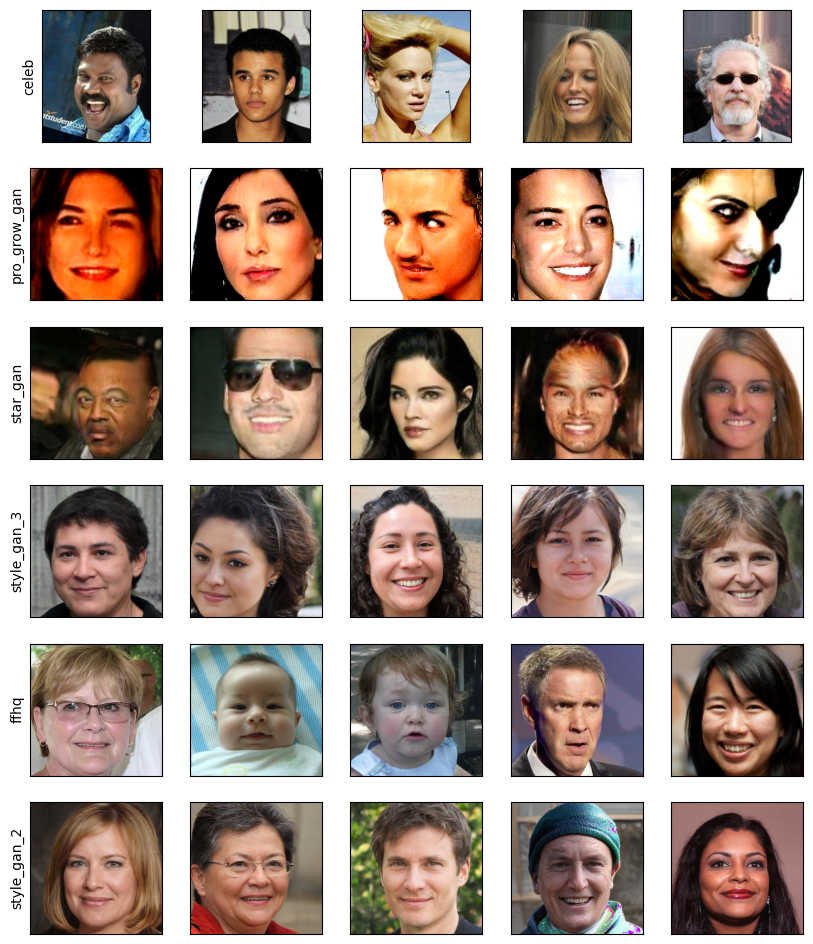

In [10]:
# Retrieve the unique GAN names and real image sources
sublabels = df_concat['sublabel'].unique()

fig, ax = plt.subplots(len(sublabels), 5, figsize = (10, 12))

# Iterate through the sublabels and take a sample of 5
for row, sub in enumerate(sublabels):
    subset = df_concat[df_concat['sublabel'] == sub].sample(5, random_state = 42)

    # Iterate through the paths of the images in the subset and open them
    for col, path in enumerate(subset['path']):
        img = mpimg.imread(path)
        ax[row, col].imshow(img, cmap = 'gray')
        ax[row, col].set(xticks = [], yticks = [], xlabel = '')
        if col == 0:
            ax[row, col].set_ylabel(sub, fontsize = 10)

plt.show()

## Overview of the Class Distribution

Since class imbalance can cause bias, we want to get an initial overview of the distribution of the training images in the two categories. We use a simple barchart, which shows that we have significantly more real images than GAN generated images. This is a relevant insight, since it highlights the need for balancing the classes.

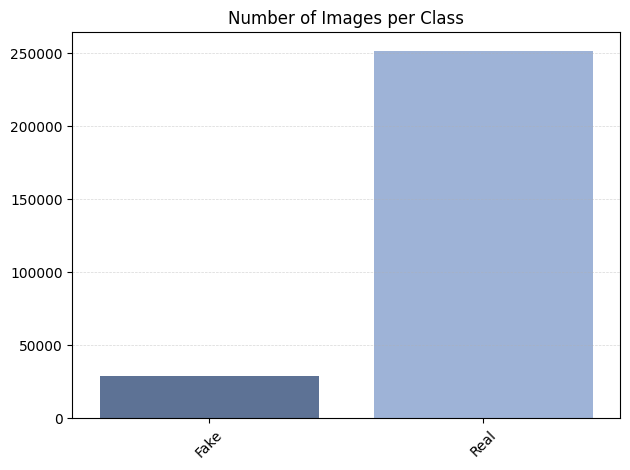

In [11]:
label_palette = {'Real': '#94b1e0', 'Fake': '#54709e'}

sns.countplot(data = df_concat, x = 'label_name', order = ['Fake', 'Real'], hue = 'label_name', palette = label_palette)
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.xticks(rotation = 45)
plt.ylabel('')
plt.xlabel('')
plt.title('Number of Images per Class')
plt.tight_layout()
plt.show()

In [12]:
# Print the number of images per class
total_images = len(df_concat)
label_counts = df_concat['label'].value_counts()
print('Number of images per class:\n')
for cl, count in label_counts.items():
    percentage = count / total_images * 100
    print(f'{cl}: {count} ({percentage:.2f})%')

Number of images per class:

1: 251854 (89.73)%
0: 28812 (10.27)%


## Overview of the Subcategory Distribution

Since the two classes real and fake are ensembled by different data sources, we also have to balance the distribution of sources within the classes. This is necessary to further minimize bias. The graph below shows that we have equal amounts of images from the four different GAN types, but significantly more images from the two sources for the real images. Notably, within the real class, the images from CelebA dominate.

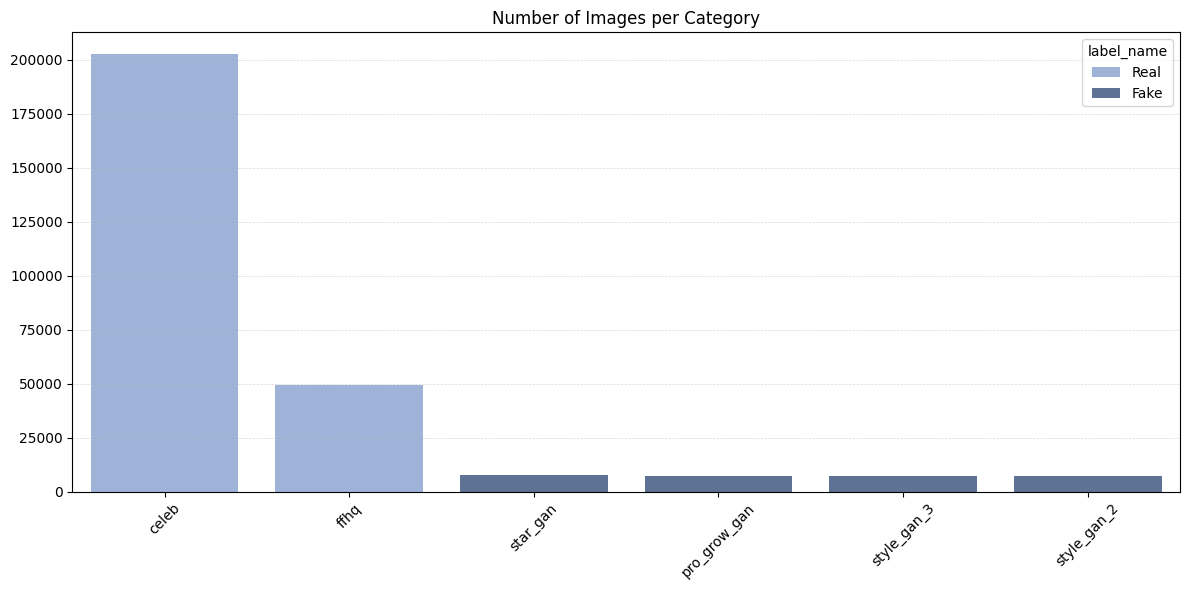

In [13]:
sublabel_palette = {
    'ffhq': '#bcd1ee',
    'celeb': '#94b1e0',
    'star_gan': '#6b7ca8',
    'style_gan_2': '#54709e',
    'style_gan_3': '#3e4d6d',
    'pro_grow_gan': '#8a7fb2'}


plt.figure(figsize = (12, 6))
sns.countplot(data = df_concat, x = 'sublabel', order = df_concat['sublabel'].value_counts().index, hue = 'label_name', palette = label_palette)
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.xticks(rotation = 45)
plt.ylabel('')
plt.xlabel('')
plt.title('Number of Images per Category')
plt.tight_layout()

plt.show()

In [14]:
# Print the number of images per GAN and real image source
sublabel_counts = df_concat['sublabel'].value_counts()
print('Number and percentage of pictures per sublabel:\n')

# Iterate through the sublabels and print the number of images and percentage
for sublabel, count in sublabel_counts.items():
    percentage = count / total_images * 100
    print(f'{sublabel}: {count} ({percentage:.2f}%)')

Number and percentage of pictures per sublabel:

celeb: 202599 (72.19%)
ffhq: 49255 (17.55%)
star_gan: 7512 (2.68%)
pro_grow_gan: 7100 (2.53%)
style_gan_3: 7100 (2.53%)
style_gan_2: 7100 (2.53%)


## Analysis of Height and Width

To ensure consistent image data, we first examine the image resolutions to determine the highest possible target size that minimizes feature loss during resizing. We can see that the images produced by the ProGAN have the lowest resolution with 128 × 128. This means we have to resize all the images to 128 × 128, to eliminate bias through image resolution. We append the height and width of every image to the dataframe to allow further analysis.

Bias can also root from different image formats. To check if we need to crop the images, we calculate the average aspect ratio for every class. We can see, that the CelebA images are not squared, showing the need to center crop images so that the model will not learn to classify images based on their format.

In [15]:
# Check for duplicates in the dataset
def get_img_size(path):
    """
    Get the size of an image.
    """
    with Image.open(path) as img:
        return img.size

# Create two new columns in the dataframe for the width and height of the images by calling the function
df_concat[['width', 'height']] = df_concat['path'].apply(get_img_size).apply(pd.Series)

# Get min and max sizes per sublabel
summary = df_concat.groupby('sublabel')[['width', 'height']].agg(['min', 'max'])

# Flatten column names
summary.columns = ['min_width', 'max_width', 'min_height', 'max_height']
summary = summary.reset_index()

# Show result
print(summary)

       sublabel  min_width  max_width  min_height  max_height
0         celeb        178        178         218         218
1          ffhq        200        200         200         200
2  pro_grow_gan        128        128         128         128
3      star_gan        200        200         200         200
4   style_gan_2        256        256         256         256
5   style_gan_3        256        256         256         256


## Format Based Biases in Classes

In [16]:
# New column for the aspect ratio of the images
df_concat['aspect_ratio'] = df_concat['width'] / df_concat['height']

# Group by the label and calculate the mean aspect ratio for each class
grouped_df_concat = df_concat.groupby('sublabel').agg({'aspect_ratio':'mean'}).rename(columns = {'path': 'count'})

print(grouped_df_concat['aspect_ratio'])

sublabel
celeb           0.816514
ffhq            1.000000
pro_grow_gan    1.000000
star_gan        1.000000
style_gan_2     1.000000
style_gan_3     1.000000
Name: aspect_ratio, dtype: float64


## Color Bias in Images

In this step, we check if all images follow the standard RGB color range from 0 to 255. This is important because if some images are outside this range, it could affect how the model learns colors and possibly lead to unfair results. We also look at the average red, green, and blue values in the different labels and sublabels/data sources. If one group has much higher or lower RGB values than others, the model might learn to classify based on color instead of real visual features. This would create a color-based bias. However, even if we can see that ProGAN images tend to be more red (also visible on the visualization of samples above), this seems to be a feature of images generated by this GAN type and the model should learn this. That is why we decided not to normalize colors.

In [17]:
def is_rgb_255(path):
    """
    Check if the image is in the rbg 255 color range.
    """
    try:
        img = Image.open(path).convert('RGB')
        arr = np.array(img)
        return arr.min() >= 0 and arr.max() <= 255
    except:
        return False

# Apply the function to all images in the dataframe
df_concat['valid_rgb'] = df_concat['path'].apply(is_rgb_255)

# Print results and check how many invalid images exist
print(f"Valid: {df_concat['valid_rgb'].sum()} of {len(df_concat)}")
print(f"Invalid: {(~ df_concat['valid_rgb']).sum()}")

Valid: 280666 of 280666
Invalid: 0


In [18]:
def get_rgb_means(path):
    """
    This function returns the average red, green, and blue values for all pixels in the input image.
    """
    with Image.open(path) as img:
        img = img.convert('RGB')
        array = np.array(img)
        # array[:, :, 0] means take all rows, all columns, and only the red/green/blue channel (index 0/1/2)
        return array[:, :, 0].mean(), array[:, :, 1].mean(), array[:, :, 2].mean()

# Create three new columns with the average red, green, and blue pixel values
df_concat[['red_mean', 'green_mean', 'blue_mean']] = df_concat['path'].apply(get_rgb_means).apply(pd.Series)

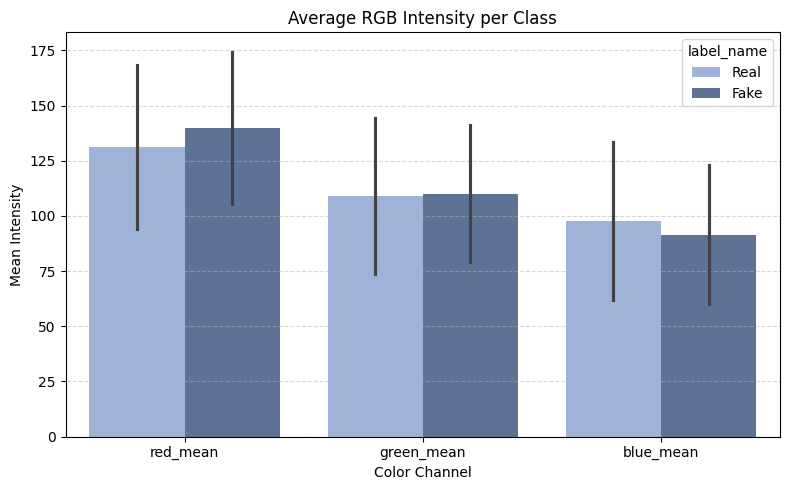

In [19]:
# Create a melted dataframe for the RGB values
rgb_melted = df_concat.melt(
    id_vars = 'label_name',
    value_vars = ['red_mean', 'green_mean', 'blue_mean'],
    var_name = 'channel',
    value_name = 'intensity')

# Create a plot
plt.figure(figsize = (8, 5))
sns.barplot(
    data=rgb_melted,
    x = 'channel',
    y = 'intensity',
    hue = 'label_name',
    errorbar = 'sd',
    palette = label_palette)
plt.title('Average RGB Intensity per Class')
plt.ylabel('Mean Intensity')
plt.xlabel('Color Channel')
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)

# Show plot
plt.tight_layout()
plt.show()

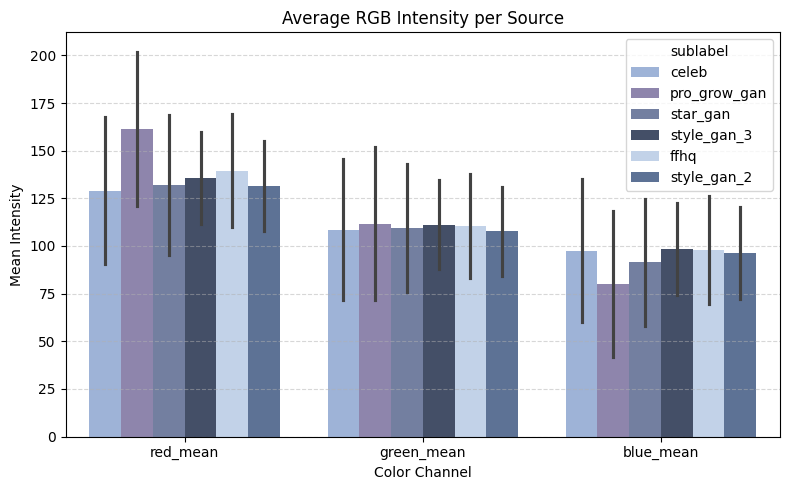

In [20]:
# Create a melted dataframe for the RGB values but this time id_vars are the sublabels
rgb_melted_sublabel = df_concat.melt(
    id_vars='sublabel',
    value_vars=['red_mean', 'green_mean', 'blue_mean'],
    var_name='channel',
    value_name='intensity')

# Create a plot for visualization of the rbg intensity for the data sources
plt.figure(figsize=(8, 5))
sns.barplot(
    data = rgb_melted_sublabel,
    x = 'channel',
    y = 'intensity',
    hue = 'sublabel',
    errorbar = 'sd',
    palette= sublabel_palette)
plt.title('Average RGB Intensity per Source')
plt.ylabel('Mean Intensity')
plt.xlabel('Color Channel')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()

# Image Preprocessing

After getting a good overview over the image data, we now have to process it to train our models. Since we retrieved data from different datasets, there might be some duplicates. Since these would skew our results, we calculate the perceived hash value for each image using the `compute_hash` function. The `phash`value is a short code that represents the visual content of an image. If two images look very similar, they will have the same value. That is why we can just check for duplicates in the `phash` column in `df_concat` and drop the duplicate images.

Additionally, we want to check for RGB anomalies, meaning images that have very high average RGB values. These are either super bright or super dark (their average values for red, green, and blue are below 5 or above 250) and we consider them as noise, since they most likely do not contain relevant information and would lead to unstable results. We define the function `is_brightness_anomaly` to append a boolean value to every image in `df_concat`. Rows with a value `True`are dropped, since they are anomalies.

## Check and Drop Duplicates

In [21]:
def compute_hash(path):
    """
    Calculate the perceptual hash of each image.
    """
    with Image.open(path) as img:
        return str(imagehash.phash(img))
    
# Create a new column in the dataframe for the perceptual hash of each image
df_concat['phash'] = df_concat['path'].apply(compute_hash)

# Check for duplicates based on the perceptual hash
number_duplicates = df_concat['phash'].duplicated().sum()

# Print the number of duplicates
print(f'Number of visual duplicates (based on phash): {number_duplicates}')

# Remove duplicates
df_concat = df_concat.drop_duplicates('phash').reset_index(drop = True)

# Print the number of images after removing duplicates
print(f'Number of images after removing duplicates: {len(df_concat)}')

Number of visual duplicates (based on phash): 963
Number of images after removing duplicates: 279703


## Check and Drop RBG Anomalies

In [22]:
def is_brightness_anomaly(path):
    """
    Check if an image is too dark or too bright based on average RGB values.
    """
    with Image.open(path) as img:
        img = img.convert('RGB')
        arr = np.array(img)
        r, g, b = arr[:, :, 0].mean(), arr[:, :, 1].mean(), arr[:, :, 2].mean()
        return r < 5 or g < 5 or b < 5 or r > 250 or g > 250 or b > 250 # return True if pixel values are in the desired range

# Create a new column indicating whether the image is too dark or too bright
df_concat['brightness_anomaly'] = df_concat['path'].apply(is_brightness_anomaly)

# Count and remove anomalies
num_anomalies = df_concat['brightness_anomaly'].sum()
print(f'Number of brightness anomalies detected: {num_anomalies}')

# Keep only valid images to reduce noise in training data
df_concat = df_concat[~ df_concat['brightness_anomaly']].reset_index(drop = True)

# Final image count
print(f'Number of images after removing anomalies: {len(df_concat)}')

Number of brightness anomalies detected: 52
Number of images after removing anomalies: 279651


As shown above, our datasets show a significant class imbalance. Since this would introduce bias, we want to balance both labels and sublabels. Even though we have at least 7,100 images for every GAN and real image source, we decided to sample down to 2,000 images per source. This was a tradeoff between computational complexity and generalization. We faced very long training times with 28,000+ images per class (7,100 per GAN × 4 GANs), so we came to the conclusion that 2,000 training samples per GAN is a good balance. The models do not take too long to train, and we still have enough data for generalization. This results in 8,000 training images per class (real/fake), so 16,000 images in total.

## Balance Sublabels

In [23]:
# Sample 2000 images from each GAN
fake_df_balanced = (
    fake_df.groupby('sublabel')
    .sample(n=2000, random_state=42)
    .reset_index(drop=True))

# Sample 4000 images from each real image source
real_df_balanced = (
    real_df.groupby('sublabel')
    .sample(n=4000, random_state=42)
    .reset_index(drop=True))

# Create a balanced dataset by concatenating the sampled real and fake dataframes
df_balanced = pd.concat([real_df_balanced, fake_df_balanced], ignore_index=True)

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the number of images in the balanced dataset
print(f'Total images: {len(df_balanced)}')
print(f'Images per class:\n{df_balanced["label"].value_counts()}')
print(f'Images per sublabel:\n{df_balanced["sublabel"].value_counts()}')


Total images: 16000
Images per class:
label
0    8000
1    8000
Name: count, dtype: int64
Images per sublabel:
sublabel
ffhq            4000
celeb           4000
pro_grow_gan    2000
star_gan        2000
style_gan_3     2000
style_gan_2     2000
Name: count, dtype: int64


## Crop Images and Process as Arrays

As we saw in the EDA section, images from the CelebA dataset are not square. That is why we have to center crop them and cut the top and bottom out in order to prevent format based bias. This is also good because the faces are in the center of the images and we only want the model to learn the features of deepfakes in the face of humans. We want as little background as possible. We define the function `center_crop_square` to crop the images, which is called by the function `load_image_array`. This transforms the images into a one dimensional array containing `img_size[height]` × `img_size[width]` × 3 values per image. `img_size` is set to 128 × 128 since the EDA has shown that this is the minimum image resolution in the data.

In [24]:
def center_crop_square(path):
    """
    Center crop an image to a square by computing the smaller dimension and cutting the image.
    """
    with Image.open(path) as img:
        w, h = img.size
        min_dim = min(w, h)
        left = (w - min_dim) // 2
        top = (h - min_dim) // 2
        cropped = img.crop((left, top, left + min_dim, top + min_dim))
        return cropped.convert('RGB')

In [25]:
# Define image size as the minimum resolution of the images
img_size = (128, 128)

def load_image_array(path):
    """
    Process the image by center cropping it to a square, resizing it and flattening it to a 1D array.
    """
    img_cropped = center_crop_square(path)
    img_resized = img_cropped.resize(img_size)
    img_array = np.array(img_resized).flatten()
    return img_array

## Seperate Images and Labels and Scale Pixels

The last step in the data preprocessing is to seperate the features from the labels and to split the data into training, validation, and test set. First, we use `np.stack` to transform the images into a two dimensional array, so that we have 128 × 128 × 3 = 49,152 features for 16000 samples (`X.shape` = (16000, 49152)). We then have to scale these features for the SVM model and we do that using `StandardScaler()`.

In [26]:
# Seperate images and labels, create a 2D array of images, and scale the pixel values using StandardScaler
X = np.stack(df_balanced['path'].apply(load_image_array))
X_scaled = StandardScaler().fit_transform(X)

# Save the labels in a variable
y = df_balanced['label'].values

We decide to split the data 30/15/15. Using a validation set is useful because it lets us do hyperparameter tuning without making predictions on the test set. This way, we can evaluate the model on data it has never seen before. It helps us get a more fair and unbiased evaluation of the model’s performance.

For the CNNs, we need the data in a different format. We created `df_train`, `df_val`, and `df_test` to serve the Image Generator. The training/validation/test split is the same to allow an objective comparison of the models.

## Train, Validation, and Test Split

In [27]:
# Split the dataset into training, validation and test sets with a 70/15/15 ratio for SVM
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42)

In [28]:
# Split the dataset into training, validation and test sets with a 70/15/15 ratio for CNN
df_train, df_temp = train_test_split(
    df_balanced,
    test_size = 0.3,
    stratify = df_balanced['label'],
    random_state = 42)

df_val, df_test = train_test_split(
    df_temp,
    test_size = 0.5,
    stratify = df_temp['label'],
    random_state = 42)

# Models

## SVM

The SVM model is our baseline which we will use as a benchmark to compare the CNNs with. For performance reasons, we do a PCA beforehand and reduce the number of features in the data. We aimed to retain 90% of the variance in the data which corresponds to 216 principal components, since we think this is a good tradeoff between computational complexity and learning performance. Another benefit of the PCA is that it improves generalization.

### Dimensionality Reduction

In [29]:
# Define pca for dimensionality reduction
pca = PCA(n_components = 216, random_state=42)

# Fit PCA on the training set and transform the training, validation and test sets
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
X_test_pca  = pca.transform(X_test)

In [30]:
# Check the explained variance ratio of the PCs
explained_total = pca.explained_variance_ratio_.sum() * 100

# Print result
print(f'Total explained variance: {explained_total:.2f}%')

Total explained variance: 90.00%


Finding the correct hyperparameter configuration is not easy. For our baseline model, we decide to perform a grid search with limited number of configurations and take the combination which achieves the highest cross validation score. Trial and error as well as research revealed that a linear kernel seems not to be a good choice for our study, since we always got the same accuracies even if we changed C and the number of iterations, which suggested that the data might not be linearly seperable. Hence, we opt for a nonlinear kernel. Following the approach from Hsu et. al (2019), we use two to the power of values between -5 and 16 as values for the regularization parameter `C` and two to the power of values between -15 and 4 for `gamma`. Since we are not sure which nonlinear kernel performs better, we want to try the `rbf` kernel and the `polynomial`kernel.

The grid search tries every combination of parameters and saves the results in `best_params`. For transparency reasons, we want to print out the best combination of hyperparameters and the cross validation score, before we train the final SVM model on them.

### GridSearch for Hyperparameter Selection

In [31]:
# Define the parameter grid with different values for the hyperparameter C and rbf/polynomial kernel (degrees for the
# polynomial kernel are not further specified, using the standard value of 3)
param_grid = {
    'C': [2**i for i in range(-5, 16, 2)],
    'gamma': [2**i for i in range(-15, 4, 4)],
    'kernel': ['rbf', 'poly']}

# Create an instance in GridSearchCV class and specify the parameters for the grid search. Afterwards, fit the model.
grid_search = GridSearchCV(
    estimator = SVC(random_state=42),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    return_train_score = True)

grid_search.fit(X_train_pca, y_train)

# Save and print the best parameters for visualization and for the SVM model
best_params = grid_search.best_params_

print(f"Best kernel: {best_params['kernel']}")
print(f"Best C: {best_params['C']}")
print(f"Best gamma: {best_params['gamma']}")

# Print validation accuracy
print(f"Best validation accuracy: {grid_search.best_score_:.2f}")

Best kernel: rbf
Best C: 2
Best gamma: 3.0517578125e-05
Best validation accuracy: 0.82


We now have the processed data and a suitable combination of hyperparameters. We are now ready to train our SVM model using `C = 2`, `gamma = 3.0517578125e-05`, and the `rbf` kernel. Since this is just the baseline model, we decide not to conduct any further hyperparameter tuning.

### Model Definition and Training

In [32]:
# Clear the cache
gc.collect()

# Create a process object to track memory usage
process_svm = psutil.Process(os.getpid())

start_time_svm = time.time()

# Create the SVC model with the optimal parameter configuration from the grid search
svm = SVC(kernel = best_params['kernel'], C = best_params['C'], gamma = best_params['gamma'], random_state = 42, max_iter = 50000, probability = True)
svm.fit(X_train_pca, y_train)

end_time_svm = time.time()

# Get absolute memory usage after training
memory_info_svm = process_svm.memory_info().rss

### Model Evaluation

We can now evaluate the performance of the model. First, we want to save the training time and the absolute memory usage. Then we use the trained model to predict the label (real/fake) for the images in the test set and we save and print relevant metrics like `test accuracy`, `precision`, `recall`, and `ROC AUC`. Together with the confusion matrix, these give us a concise overview of the model performance.

In [33]:
# Calculate the training time
runtime_svm = (end_time_svm - start_time_svm) / 60

# Calculate the memory usage in MB
memory_usage_svm = memory_info_svm / (1024 ** 3)

# Print the training time and memory usage
print(f'Training time for SVM: {runtime_svm:.2f} minutes')
print(f'Memory usage for SVM: {round(memory_usage_svm, 2)} GB')

Training time for SVM: 1.75 minutes
Memory usage for SVM: 16.42 GB


In [34]:
# Make predictions on the test set
y_pred_svm_prob = svm.predict_proba(X_test_pca)[:, 1]
y_pred_svm = svm.predict(X_test_pca)

# Calculate accuracy on the test set
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Test Accuracy: {test_accuracy_svm:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
print('Confusion Matrix:')
print(cm)

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_svm, target_names=['Fake', 'Real']))

# Calculate the AUC ROC score
roc_auc_svm = roc_auc_score(y_test, y_pred_svm_prob)
print(f'ROC AUC Score: {roc_auc_svm:.2f}')

precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

Test Accuracy: 0.83
Confusion Matrix:
[[ 971  209]
 [ 202 1018]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.83      0.82      0.83      1180
        Real       0.83      0.83      0.83      1220

    accuracy                           0.83      2400
   macro avg       0.83      0.83      0.83      2400
weighted avg       0.83      0.83      0.83      2400

ROC AUC Score: 0.90


With an F1 score of 83%, we can say that our baseline model performs quite well. Precision and recall are balanced across both classes, and the confusion matrix shows that the model handles both real and fake images similarly. The ROC AUC score of 0.90 also confirms that the model can separate the two classes reliably.

## Image Generators

The CNNs do not take the two-dimensional arrays as inputs, like the SVM does. We define image generators to load and preprocess the images directly from the file paths. This allows us to resize the images, normalize the pixel values, and apply augmentation during training. This is useful to support generalization of the model and reduce overfitting. It is also memory-efficient, since the images are loaded in small batches instead of all at once. After trial and error and another grid search, we came to the conclusion that 32 is a suitable batch size. We also tried a batch size of 64 for this did not enhance the learning process and led to much higher computational complexity.

In [35]:
batch_size = 32

# Define image generator for training set and rescaling and augmentation on the fly
train_gen = ImageDataGenerator(
    rescale = 1.0 / 255,        
    zoom_range = 0.2,                 
    brightness_range = [0.7, 1.3],    
    fill_mode='nearest')

# Define image generator for validation and test sets
val_test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

# Training image generator  for CNN using flow_from_dataframe
train_data_gen = train_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'path',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle = True)

# Validation image generators for CNN using flow_from_dataframe
val_data_gen = val_test_datagen.flow_from_dataframe(
    dataframe = df_val,
    x_col = 'path',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle = False)

# Test image generators for CNN using flow_from_dataframe
test_data_gen = val_test_datagen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'path',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle = False)

Found 11200 validated image filenames.
Found 2400 validated image filenames.
Found 2400 validated image filenames.


## Shallow CNN

We will start with a shallow CNN, which is rather simple and only has two convolutional layers. Each layer uses ReLU activation, batch normalization, and max pooling. After the convolutional part, we flatten the output and add a dense layer with a dropout rate of 0.4 to support generalization. The final output layer uses a sigmoid activation for binary classification. The filter size is 3×3 since our previous grid search and trial and error has shown that a smaller kernel results in a better performance.

### Model Definition

In [36]:
# Define the shallow CNN model with two convolutional layers
shallow_cnn = Sequential([
    # First layer with 32 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second layer with 64 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten the output and add a dense layer with 64 units, ReLU activation and dropout for generalization
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.4),

    # Output layer with 1 unit and sigmoid activation for binary classification
    Dense(1, activation = 'sigmoid')])

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-15 20:51:59.041185: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [37]:
shallow_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,305 (14.14 MB)

 Trainable params: 3,706,113 (14.14 MB)

 Non-trainable params: 192 (768.00 B)

### Model Training

After we built our CNN, we have to compile and fit it. We decide to use the Adam optimizer with a low learning rate of 0.00001, also resulting from our grid search and trial and error process. Higher learning rates showed that the model struggles to converge and to improve steadily as the model tends to overshoot during gradient descent in backpropagation.

To prevent overfitting, we used `EarlyStopping`. We set patience to 2 because the training was very stable and the validation loss decreased steadily. When we tried higher values, the model started to overfit, which we wanted to avoid. At some point during training, the validation accuracy stops improving while the training accuracy keeps going up to 100%. That is why we set `restore_best_weights = True`, so the model keeps the weights from the best moment during training. We trained the model for a maximum of 30 epochs, but this number was never reached because early stopping stopped the training earlier.

In [38]:
shallow_cnn.compile(
    # We use Adam optimizer with a learning rate of 0.00001
    optimizer = Adam(learning_rate = 0.00001),
    # Binary crossentropy loss function is the best for binary classification
    loss = 'binary_crossentropy',
    # Accuracy metric for evaluation
    metrics=['accuracy'])

# Define early stopping with a patience of 2 epochs to prevent the model from overfitting
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True) # restores the best weights before the model starts to overfit

start_time_shallow = time.time()

# Clear the cache
gc.collect()

# Create a process object to track memory usage
process_shallow = psutil.Process(os.getpid())

history_shallow = shallow_cnn.fit(
    train_data_gen,
    validation_data=val_data_gen,
    # 30 Epochs for training
    epochs = 30,
    # Callbacks for early stopping and learning rate reduction
    callbacks = [early_stop],
    # Print steps per epoch and validation steps
    verbose=1)

end_time_shallow = time.time()

memory_info_shallow = process_shallow.memory_info().rss

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 240ms/step - accuracy: 0.6470 - loss: 0.6747 - val_accuracy: 0.5929 - val_loss: 0.6678
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.7629 - loss: 0.4745 - val_accuracy: 0.8171 - val_loss: 0.3881
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 241ms/step - accuracy: 0.7951 - loss: 0.4324 - val_accuracy: 0.8350 - val_loss: 0.3551
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.8209 - loss: 0.3908 - val_accuracy: 0.8313 - val_loss: 0.3522
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.8326 - loss: 0.3616 - val_accuracy: 0.8433 - val_loss: 0.3332
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 236ms/step - accuracy: 0.8454 - loss: 0.3510 - val_accuracy: 0.8546 - val_loss: 0.3190
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.8505 - loss: 0.3336 - val_accuracy: 0.8604 - val_loss: 0.3164
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.8619 - loss: 0

### Model Evaluation

In [39]:
# Calculate the training time
runtime_shallow_cnn = (end_time_shallow - start_time_shallow) / 60

# Calculate the absolute memory usage
memory_usage_shallow = memory_info_shallow / (1024 ** 3)

# Print the training time and memory usage
print(f'Training time: {runtime_shallow_cnn:.2f} minutes')
print(f'Memory usage: {round(memory_usage_shallow, 2)} GB')

Training time: 29.37 minutes
Memory usage: 18.56 GB


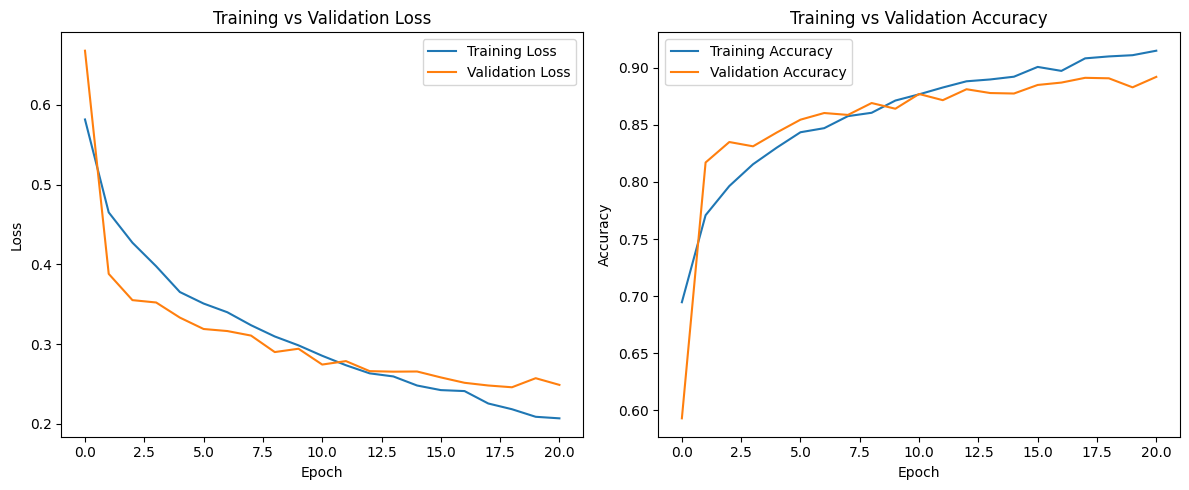

In [40]:
# Save training history for visualization
loss_shallow = history_shallow.history['loss']
val_loss_shallow = history_shallow.history['val_loss']
acc_shallow = history_shallow.history['accuracy']
val_acc_shallow = history_shallow.history['val_accuracy']
epochs_range_shallow = range(len(loss_shallow))

# Create a plot
plt.figure(figsize = (12, 5))

# Loss plot as a subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_shallow, loss_shallow, label = 'Training Loss')
plt.plot(epochs_range_shallow, val_loss_shallow, label = 'Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot as a subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_shallow, acc_shallow, label = 'Training Accuracy')
plt.plot(epochs_range_shallow, val_acc_shallow, label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [65]:
# Evaluate the model on the test set
test_loss_shallow, test_accuracy_shallow = shallow_cnn.evaluate(test_data_gen)
print(f'Test Loss: {test_loss_shallow:.2f}')
print(f'Test Accuracy: {test_accuracy_shallow:.2f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8876 - loss: 0.2539
Test Loss: 0.25
Test Accuracy: 0.89


In [42]:
# Predict probabilities and labels of the test set
y_pred_shallow_probs = shallow_cnn.predict(test_data_gen).flatten()
y_pred_shallow = np.where(y_pred_shallow_probs > 0.5, 1, 0)

# Get the true labels of the test set
y_true_shallow = df_test['label'].values

# Print confusion matrix
cm = confusion_matrix(y_true_shallow, y_pred_shallow)
print('Confusion matrix:')
print(cm)

# Print classification report
print('Classification report:')
print(classification_report(y_true_shallow, y_pred_shallow, target_names = ['Fake', 'Real']))

precision_shallow = precision_score(y_true_shallow, y_pred_shallow)
recall_shallow = recall_score(y_true_shallow, y_pred_shallow)
f1_shallow = f1_score(y_true_shallow, y_pred_shallow)
roc_auc_shallow = roc_auc_score(y_true_shallow, y_pred_shallow_probs)

print(f'ROC AUC Score: {roc_auc_shallow:.2f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step
Confusion matrix:
[[1068  132]
 [ 128 1072]]
Classification report:
              precision    recall  f1-score   support

        Fake       0.89      0.89      0.89      1200
        Real       0.89      0.89      0.89      1200

    accuracy                           0.89      2400
   macro avg       0.89      0.89      0.89      2400
weighted avg       0.89      0.89      0.89      2400

ROC AUC Score: 0.96


The shallow CNN gives us solid results. We reach 89% test accuracy with balanced precision, recall, and F1-score. All three metrics are exactly the same, which shows that the model performs equally well for both classes. This is also confirmed by the confusion matrix. The learning curves show a stable training process without strong overfitting (only about 2%). The training took around 29 minutes and used 18.6 GB of memory which seems reasonable. Overall, we are happy with the performance.

## Deep CNN

The next step is to find out if a deeper CNN can give us better results. We add two more convolutional layers compared to the shallow CNN. We do not add more layers, because after four convolutional and pooling steps the spatial size is already reduced to 8×8. If we add one more layer, it would go down to 4×4, which is very small and does not contain much useful information anymore. So we decided that four layers is a good point to stop.

We used almost the same hyperparameters, also resulting from our trial and error process as well as a grid search. One difference, however, is that we added L2 regularization with a `lambda = 0.001` in addition to the drop out rate of 0.4, which was also found through trial and error. This is helpful as the deeper architecture is more prone to overfitting.

### Model Definition

In [43]:
# Build a deep CNN model with more convolutional layers and regularization
deep_cnn = Sequential([
    # First layer with 32 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (128, 128, 3), kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second layer with 64 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Third layer with 128 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(128, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Fourth layer with 256 filters, 3x3 kernel size, ReLU activation and batch normalization
    Conv2D(256, (3, 3), activation = 'relu', kernel_regularizer = l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Flatten the output and add a dense layer with 256 units, ReLU activation and dropout for generalization
    Flatten(),
    Dense(256, activation = 'relu', kernel_regularizer = l2(0.001)),
    Dropout(0.4),

    # Output layer with 1 unit and sigmoid activation for binary classification
    Dense(1, activation = 'sigmoid')])

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
deep_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,750,145 (10.49 MB)

 Trainable params: 2,749,185 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

### Model Training

For training, we use the same hyperparameters as in the shallow CNN. While it is nearly impossible to test every combination of all hyperparameters, the grid search and our experimentation has revealed that this is a very suitable combination. We are mostly aiming for a stable training process and no overfitting.

In [45]:
# Compile the model
deep_cnn.compile(
    # Adam optimizer with a learning rate of 0.00001 for stable training
    optimizer = Adam(learning_rate = 0.00001),
    # Binary crossentropy loss function for binary classification
    loss = 'binary_crossentropy',
    # Accuracy metric for evaluation
    metrics = ['accuracy'])

# Define early stopping with a patience of 2 epochs to prevent the model from overfitting
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True)

# Set start time for time tracking and comparison
start_time_deep = time.time()

# Clear the cache
gc.collect()

# Create a process object to track memory usage
process_deep = psutil.Process(os.getpid())

# Fit the model on the training set with validation data
history_deep_cnn = deep_cnn.fit(
    train_data_gen,
    validation_data = val_data_gen,
    # 30 Epochs for training
    epochs = 30,
    # Callbacks for early stopping and learning rate reduction
    callbacks = [early_stop],
    # Print steps per epoch and validation steps
    verbose = 1)

# Stop the time when the model finishes training
end_time_deep = time.time()

# End memory usage
memory_info_deep = process_deep.memory_info().rss


Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 99s 275ms/step - accuracy: 0.5997 - loss: 1.7044 - val_accuracy: 0.6621 - val_loss: 1.4117
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 97s 278ms/step - accuracy: 0.7130 - loss: 1.3706 - val_accuracy: 0.7783 - val_loss: 1.2483
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 97s 275ms/step - accuracy: 0.7554 - loss: 1.2881 - val_accuracy: 0.8029 - val_loss: 1.2177
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.7789 - loss: 1.2457 - val_accuracy: 0.8062 - val_loss: 1.1958
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 96s 275ms/step - accuracy: 0.7985 - loss: 1.2151 - val_accuracy: 0.8142 - val_loss: 1.1789
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 269ms/step - accuracy: 0.8233 - loss: 1.1681 - val_accuracy: 0.8333 - val_loss: 1.1482
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 267ms/step - accuracy: 0.8190 - loss: 1.1623 - val_accuracy: 0.8475 - val_loss: 1.1310
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 94s 268ms/step - accuracy: 0.8328 - loss: 1

### Model Evaluation

In [46]:
# Calculate the training time
runtime_deep_cnn = (end_time_deep - start_time_deep) / 60

# Calculate Memory usage in MB
memory_usage_deep = memory_info_deep / (1024 ** 3)

# Print the training time and memory usage
print(f'Training time: {runtime_deep_cnn:.2f} minutes')
print(f'Memory usage: {round(memory_usage_deep, 2)} GB')

Training time: 44.50 minutes
Memory usage: 22.57 GB


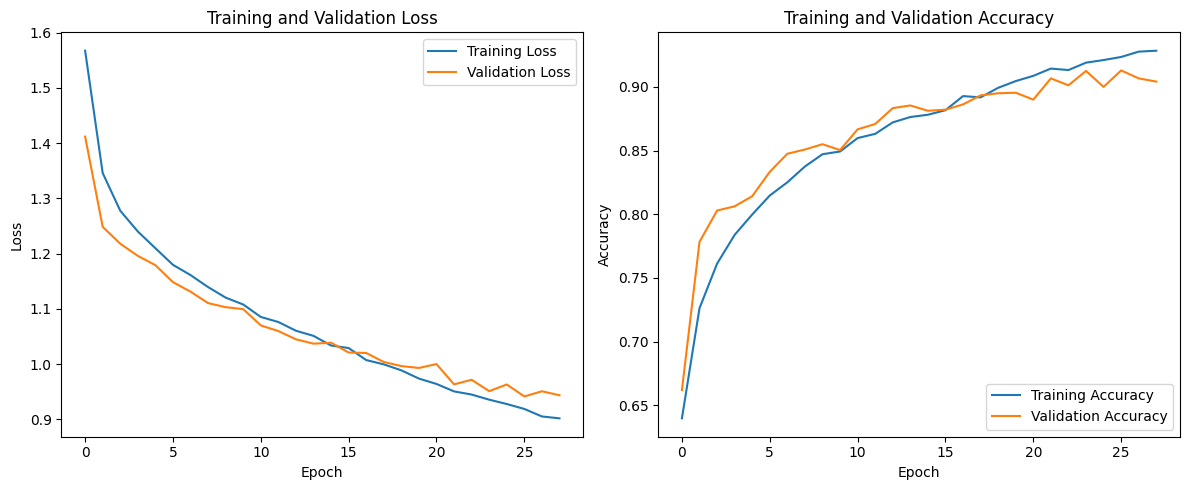

In [47]:
# Save training history for visualization
acc_deep = history_deep_cnn.history['accuracy']
val_acc_deep = history_deep_cnn.history['val_accuracy']
loss_deep = history_deep_cnn.history['loss']
val_loss_deep = history_deep_cnn.history['val_loss']
epochs_range_deep = range(len(acc_deep))

# Create a plot
plt.figure(figsize = (12, 5))

# Loss plot as a subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_deep, loss_deep, label = 'Training Loss')
plt.plot(epochs_range_deep, val_loss_deep, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

# Accuracy plot as a subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_deep, acc_deep, label = 'Training Accuracy')
plt.plot(epochs_range_deep, val_acc_deep, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Show plot
plt.tight_layout()
plt.show()

In [48]:
# Evaluate the model on the test set
test_loss_deep, test_accuracy_deep = deep_cnn.evaluate(test_data_gen, verbose=1)
print(f'Test Accuracy: {test_accuracy_deep:.2f}')
print(f'Test Loss: {test_loss_deep:.2f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9036 - loss: 0.9546
Test Accuracy: 0.91
Test Loss: 0.94


In [49]:
# Predict probabilites and labels of the test set
y_pred_deep_prob = deep_cnn.predict(test_data_gen).flatten()
y_pred_deep = np.where(y_pred_deep_prob > 0.5, 1, 0)

# Get the true labels of the test set
y_true_deep = df_test['label'].values

# Print confusion matrix
cm = confusion_matrix(y_true_deep, y_pred_deep)
print('Confusion Matrix:')
print(cm)

# Print classification report
print('Classification Report:')
print(classification_report(y_true_deep, y_pred_deep, target_names = ['Fake', 'Real']))

precision_deep = precision_score(y_true_deep, y_pred_deep)
recall_deep = recall_score(y_true_deep, y_pred_deep)
f1_deep = f1_score(y_true_deep, y_pred_deep)
roc_auc_deep = roc_auc_score(y_true_deep, y_pred_deep_prob)

print(f'ROC AUC Score: {roc_auc_deep:.2f}')

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
Confusion Matrix:
[[1073  127]
 [  85 1115]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.89      0.91      1200
        Real       0.90      0.93      0.91      1200

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400

ROC AUC Score: 0.97


The deep CNN reached an accuracy of 91% and shows a balanced precision, recall, and F1 score for both classes. The values are all 0.91, which means the model works well on both real and fake images. The confusion matrix confirms that the predictions are very consistent. The training and validation curves show a stable learning process. There is no strong overfitting, and validation accuracy stays close to training accuracy (Only around 1% difference). Training took longer compared to the shallow CNN (about 43 minutes), and memory usage was higher (23 GB), but the performance improved by 2%. We can say that adding two more layers helped the model to learn more complex patterns without overfitting. The regularization seems to work well.

### Compare Misclassification Rate of Different GANs

After training our three models, we want to find an answer to our sub research question 1 (Which GAN-generated facial images are most often misclassified as real by the model?). We add a column to the dataframe `df_test` which adds the predicted labels (by the deep CNN) to the test images and their corresponding labels. Then we filter to only keep the images that are GAN-generated.

After that, we create `df_gan_evaluation` which groups `df_test` by sublabel (GAN type) and applies an aggregate function to the column `prediction_deep`, which calculates the mean of the predicted label (which is the mean of the images among the GANs that were classified as real images, even though actually they are fake).

In [50]:
# Save the predictions in the test set for later analysis
df_test['prediction_deep'] = y_pred_deep

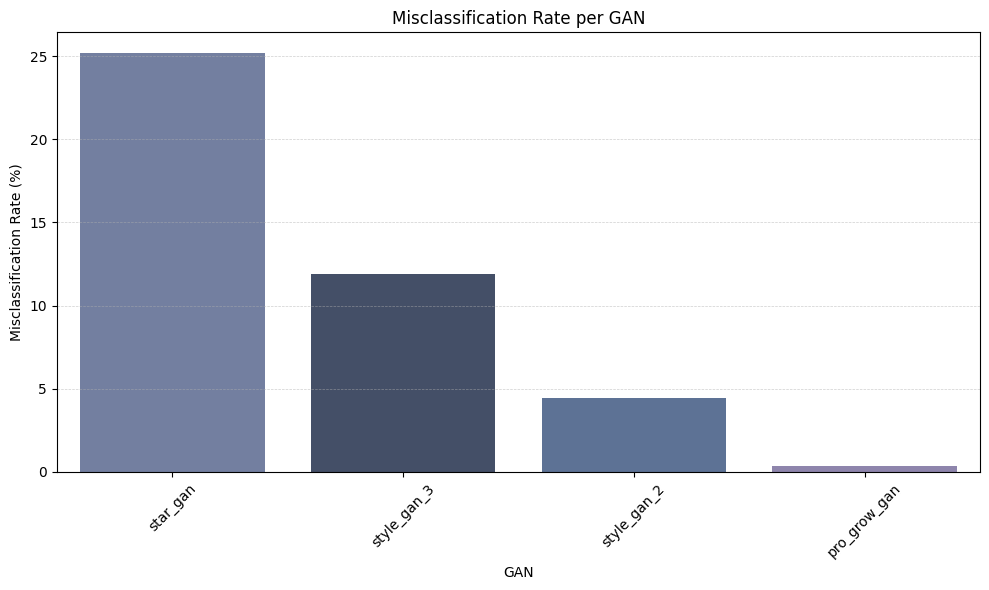

In [51]:
# Isolate the GAN images from the test set
df_test_gan_only = df_test[df_test['label'] == 0]

# Create a new dataframe with the detection rate for each GAN
df_gan_evaluation = df_test_gan_only.groupby('sublabel').agg({'prediction_deep': lambda x: x.mean() * 100}).reset_index()

# Rename columns
df_gan_evaluation.rename(columns = {'sublabel': 'GAN', 'prediction_deep': 'Misclassification Rate'}, inplace = True)
df_gan_evaluation = df_gan_evaluation.sort_values('Misclassification Rate', ascending = False)

# Create a plot to show the detection rate per GAN
plt.figure(figsize = (10, 6))
sns.barplot(data = df_gan_evaluation, x = 'GAN', y = 'Misclassification Rate', hue = 'GAN', palette = sublabel_palette)
plt.title('Misclassification Rate per GAN')
plt.xlabel('GAN')
plt.ylabel('Misclassification Rate (%)')
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.6)

# Show plot
plt.tight_layout()
plt.show()

In [53]:
for index, row in df_gan_evaluation.iterrows():
    print(f'GAN: {row["GAN"]}, Detection rate: {row["Misclassification Rate"]:.2f}%')

GAN: star_gan, Detection rate: 25.17%
GAN: style_gan_3, Detection rate: 11.90%
GAN: style_gan_2, Detection rate: 4.45%
GAN: pro_grow_gan, Detection rate: 0.34%


We can conclude that the misclassification of images from the ProGAN is very low with 0.34%. Notably, StarGAN seems to be the hardest to detect, which seems a bit surprising to us since (at least for the human eye), these images seem very easy to distinguish from real face images. This raises the question if the model is biased for example because of the high average of the red pixel values or if we reach other data limitations.

### Plotting Examples of False Positives

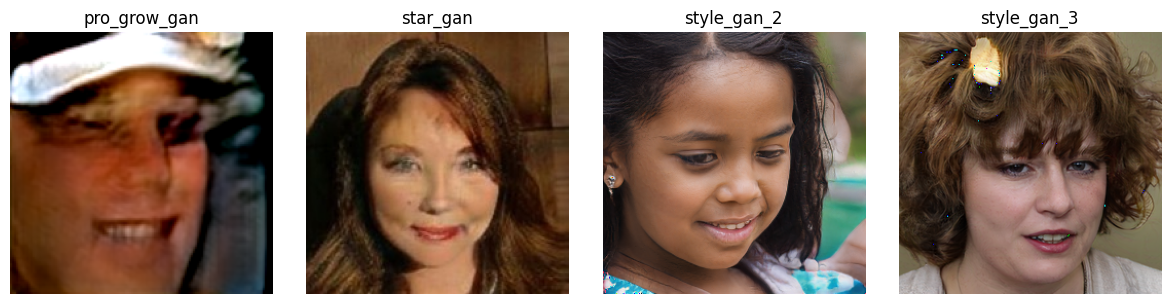

In [54]:
# Subset the dataframe with the predictions of the deep cnn and the true image labels and only take the fake images that were incorrectly identified as real
false_positives = df_test[(df_test['label'] == 0) & (df_test['prediction_deep'] == 1)]

# select the first false positive of each label in the order which should be visualized
selected_false_positives = false_positives.groupby('sublabel').first().reset_index()

fig, axes = plt.subplots(1, 4, figsize = (12, 3))

# Loop through the samples in selected_false_negatives and open the images
for i in range(len(selected_false_positives)):
    row = selected_false_positives.iloc[i]
    img = mpimg.imread(row['path'])
    axes[i].imshow(img)
    axes[i].set_title(row['sublabel'])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Model Comparison

## Computational Metrics

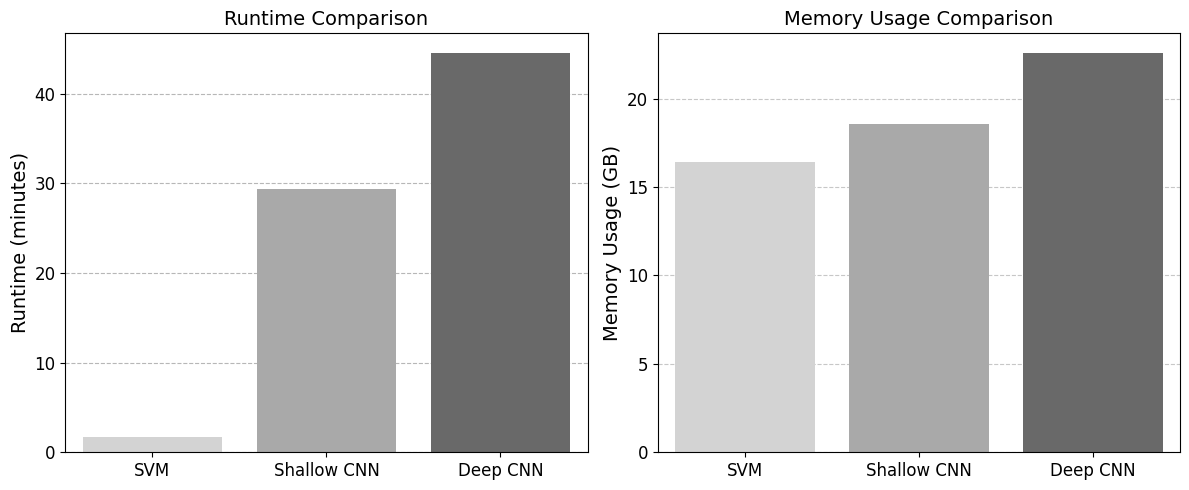

In [55]:
models = ['SVM', 'Shallow CNN', 'Deep CNN']
runtimes = [runtime_svm, runtime_shallow_cnn, runtime_deep_cnn]
memory_usages_gb = [memory_usage_svm, memory_usage_shallow, memory_usage_deep]

model_palette = {
    'SVM': '#d3d3d3',
    'Shallow CNN': '#a9a9a9',
    'Deep CNN': '#696969'}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Create subplots for runtime and memory usage
sns.barplot(x = models, y = runtimes, ax = axes[0], hue = models, palette = model_palette)
axes[0].set_title('Runtime Comparison', fontsize = 14)
axes[0].set_ylabel('Runtime (minutes)', fontsize = 14)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_axisbelow(True)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.9)

sns.barplot(x = models, y = memory_usages_gb, ax = axes[1], hue = models, palette = model_palette, legend = False)
axes[1].set_title('Memory Usage Comparison', fontsize = 14)
axes[1].set_ylabel('Memory Usage (GB)', fontsize = 14)
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_axisbelow(True)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Performance Summary

In [56]:
results = [
    {
        'Model': 'SVM',
        'Test Accuracy': round(test_accuracy_svm, 2),
        'Precision': round(precision_svm, 2),
        'Recall': round(recall_svm, 2),
        'F1': round(f1_svm, 2),
        'ROC AUC': round(roc_auc_svm, 2),
        'Runtime (minutes)': round(runtime_svm, 2),
        'Memory Usage (GB)': round(memory_usage_svm, 2)},
    {
        'Model': 'Shallow CNN',
        'Test Accuracy': round(test_accuracy_shallow, 2),
        'Precision': round(precision_shallow, 2),
        'Recall': round(recall_shallow, 2),
        'F1': round(f1_shallow, 2),
        'ROC AUC': round(roc_auc_shallow, 2),
        'Runtime (minutes)': round(runtime_shallow_cnn, 2),
        'Memory Usage (GB)': round(memory_usage_shallow, 2)},
    {
        'Model': 'Deep CNN',
        'Test Accuracy': round(test_accuracy_deep, 2),
        'Precision': round(precision_deep, 2),
        'Recall': round(recall_deep, 2),
        'F1': round(f1_deep, 2),
        'ROC AUC': round(roc_auc_deep, 2),
        'Runtime (minutes)': round(runtime_deep_cnn, 2),
        'Memory Usage (GB)': round(memory_usage_deep, 2)}]

In [57]:
# Save results in a pandas DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

         Model  Test Accuracy  Precision  Recall    F1  ROC AUC  \
0          SVM           0.83       0.83    0.83  0.83     0.90   
1  Shallow CNN           0.89       0.89    0.89  0.89     0.96   
2     Deep CNN           0.91       0.90    0.93  0.91     0.97   

   Runtime (minutes)  Memory Usage (GB)  
0               1.75              16.42  
1              29.37              18.56  
2              44.50              22.57  


The SVM is the fastest model with the lowest memory usage. It only takes around 1.5 minutes to train and uses 16 GB memory. But it also has the lowest accuracy with 83 percent. The shallow CNN performs better with 89 percent accuracy. It takes more time, around 29 minutes, and uses slightly more memory with 18.6 GB. Still, it is much faster than the deep CNN. The deep CNN gives the best results with 91 percent accuracy and the highest precision, recall, and F1-score. But it also needs the most resources, with 44 minutes training time and 23 GB memory. So we get better performance, but it comes with higher cost.

# Application of the Shallow CNN on Unseen Projected GAN Generated Images

Lastly, we want to answer our sub research question two (how does the model perform on facial images generated by an unseen GAN-type?). Here, the Projected GAN images from the beginning come into play. Like the other images, we have to preprocess them first and we apply the same steps as in the beginning, however, we will not do a comprehensive EDA. Since our deep CNN performs best, we will use this one to classify the Projected GAN images. To check if the model actually learned the features of the GAN-generated images, we also added real images and balanced the test set.

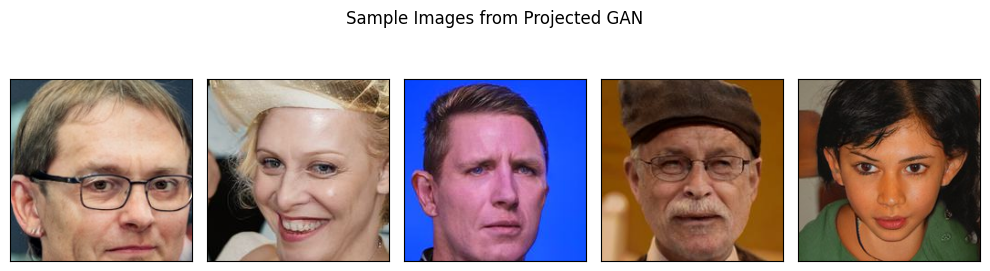

In [58]:
subset = df_projected_gans.sample(5, random_state = 42)

fig, ax = plt.subplots(1, 5, figsize = (10, 3))

for i, path in enumerate(subset['path']):
    img = mpimg.imread(path)
    ax[i].imshow(img, cmap = 'gray')
    ax[i].set(xticks = [], yticks = [], xlabel = '')

fig.suptitle('Sample Images from Projected GAN', fontsize = 12)

plt.tight_layout()
plt.show()

## Preprocess the Projected GAN Images

In [59]:
# Calculate the width and height of the projected GAN images as well as aspect ratio
df_projected_gans[['width', 'height']] = df_projected_gans['path'].apply(get_img_size).apply(pd.Series)
df_projected_gans['aspect_ratio'] = df_projected_gans['width'] / df_projected_gans['height']

print(f'Minimum width: {df_projected_gans['width'].min()}, Maximum width: {df_projected_gans['width'].max()}')
print('\n')
print(f'Minimum aspect ratio: {df_projected_gans['aspect_ratio'].min()}, maximum aspect ratio: {df_projected_gans['aspect_ratio'].max()}')


Minimum width: 200, Maximum width: 200


Minimum aspect ratio: 1.0, maximum aspect ratio: 1.0


In [60]:
# Get the number of projected GAN images for balance with real images to create a new test set
number_projected_gan_test_images = len(df_projected_gans)

# Sample half of this amount from the ffhq real images for class balance
real_ffqh_sample = real_df[real_df['sublabel'] == 'ffhq'].sample(number_projected_gan_test_images // 2, random_state=42)
real_ffqh_sample['label'] = 'real'

# Sample half of this amount from the celeb real images for class balance
real_celeb_sample = real_df[real_df['sublabel'] == 'celeb'].sample(number_projected_gan_test_images // 2, random_state=42)
real_celeb_sample['label'] = 'real'

# Concat the two samples to a dataframe with unseen real images and shuffle the rows
unseen_reals = pd.concat([real_ffqh_sample, real_celeb_sample], ignore_index=True).sample(frac = 1, random_state = 42).reset_index(drop = True)

In [61]:
# Concat the dataset with the unseen real and projected GAN images
df_real_projected = pd.concat([df_projected_gans, unseen_reals], ignore_index=True).sample(frac = 1, random_state = 42).reset_index(drop = True)

# Print the number of images in the unseen dataset
print(f'Total images: {len(df_real_projected)}')
print(f'Images per class:\n{df_real_projected["label"].value_counts()}')
print(f'Images per sublabel:\n{df_real_projected["sublabel"].value_counts()}')

Total images: 3281
Images per class:
label
fake    1641
real    1640
Name: count, dtype: int64
Images per sublabel:
sublabel
celeb    820
ffhq     820
Name: count, dtype: int64


## Classify the Unseen GAN Images

In [62]:
# Define an image generator to prepare the unseen projected GAN images and unseen real images to be fed to the model
projected_data_gen = val_test_datagen.flow_from_dataframe(
    dataframe = df_real_projected,
    x_col = 'path',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False)

Found 3281 validated image filenames belonging to 2 classes.


In [63]:
# Predict probabilities and labels of the unseen projected GAN images and unseen real images
projected_probs_shallow = deep_cnn.predict(projected_data_gen).flatten()

# Get the predicted labels
y_pred_projected = np.where(projected_probs_shallow > 0.5, 1, 0)

# Get the true labels
y_true_projected = projected_data_gen.classes

/home/ucloud/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


## Evaluate the Results

In [64]:
# Print confusion matrix
cm = confusion_matrix(y_true_projected, y_pred_projected)
print('Confusion Matrix:')
print(cm)

# Print classification report
print('Classification Report:')
print(classification_report(y_true_projected, y_pred_projected, target_names=['Fake', 'Real']))

Confusion Matrix:
[[ 236 1405]
 [ 123 1517]]
Classification Report:
              precision    recall  f1-score   support

        Fake       0.66      0.14      0.24      1641
        Real       0.52      0.93      0.67      1640

    accuracy                           0.53      3281
   macro avg       0.59      0.53      0.45      3281
weighted avg       0.59      0.53      0.45      3281



When we test the model on the unknown GAN type, performance drops. The overall accuracy is 59 percent. The model still finds most real images (recall 0.88), but it struggles with fake ones. The recall for fake is only 0.24, which means the model misses many fake images and predicts them as real. This shows that the model learned features specific to the GAN types seen during training, and does not generalize well to new, unseen GANs, which highlights a limitation of our study.